# BNN in PyTorch
Here we build our own Bayesian Neural Network using Bayes by Backprop 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import math
import os
import pickle

## 1. Toy data

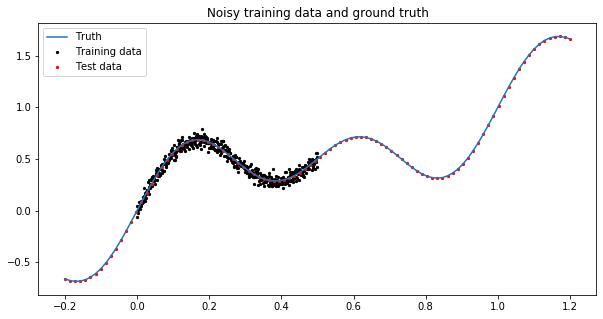

In [3]:
def f(x, sigma = 0.04):
    epsilon = torch.distributions.Normal(0,sigma).sample(sample_shape=torch.Size(x.shape))
    out = x.add(epsilon) + 0.3*np.sin(2*np.pi*x) + 0.3*np.sin(4*np.pi*x)
    return out

trainSamples = 500
testSamples = 100

trainset = torch.linspace(0, 0.5, trainSamples).reshape(-1,1) 
testset = torch.linspace(-0.2, 1.2, testSamples).reshape(-1,1)
trainset_targets = f(trainset)
testset_targets = f(testset, sigma=0.0)
    
groundTruth = torch.linspace(-0.2, 1.2, testSamples).reshape(-1,1)
groundTruth_targets = f(groundTruth, sigma=0.0)

plt.figure(figsize=(10,5))
plt.plot(groundTruth, groundTruth_targets, label='Truth')
plt.scatter(trainset, trainset_targets, marker='.', c = 'black', s = 20, label='Training data')
plt.scatter(testset, testset_targets, marker='.', c = 'red', s = 20, label='Test data')
plt.title('Noisy training data and ground truth')
plt.legend();

In [4]:
# Make a custom dataloader
class DataLoader:
    def __init__(self, inputs, targets, batchSize):
        assert inputs.shape[0] == targets.shape[0]
        
        # Prepare the batch dimensions and counter
        self.batchSize = batchSize if batchSize <= inputs.shape[0] else inputs.shape[0] 
        self.n = inputs.shape[0]
        self.batchNums = self.n // self.batchSize
        self.counter = 1
        
        # Stack the inputs and the targets
        self.inputs = torch.autograd.Variable(inputs)
        self.targets = torch.autograd.Variable(targets)
        self.output = torch.stack([inputs, targets]) 
        self.indices = torch.randperm(self.n)
    
    def count(self):
        if self.counter >= self.batchNums:
            self.counter = 1
            self.indices = torch.randperm(self.n)
        else:
            self.counter += 1
        
    def getBatch(self):
        left  = (self.counter-1)*self.batchSize
        right = self.counter*self.batchSize
        outIndices = self.indices[left:right]
        self.count()
        return self.inputs[outIndices], self.targets[outIndices]
    
test = DataLoader(trainset, trainset_targets, 64)


In [6]:
# Make a mixture of Gaussians: 
class ScaleMixtureGaussian:
    def __init__(self, mu1, mu2, sigma1, sigma2, mix, eps = 1e-7):
        assert sigma1 > 0
        assert sigma2 > 0
        
        sigma1 += eps if sigma1 == 0 else 0
        sigma2 += eps if sigma2 == 0 else 0
        
        self.gaussian1 = torch.distributions.Normal(mu1,sigma1)
        self.gaussian2 = torch.distributions.Normal(mu2,sigma2)
        self.mix = mix
    
    def log_prob(self, value):
        prob1 = torch.exp(self.gaussian1.log_prob(value))
        prob2 = torch.exp(self.gaussian2.log_prob(value))
        return (torch.log(self.mix * prob1 + (1-self.mix) * prob2)).sum()
    


## 2. A BNN layer in PyTorch

In [6]:
class BNNLayer(torch.nn.Module):
    def __init__(self, inFeatures, outFeatures, KLweight, prior_var=1., prior_mix=0.3):

        # Initialize layer + layer dimensions
        super(BNNLayer, self).__init__()
        self.KLweight = KLweight

        # Initialize mu and rho parameters for the weights
        self.w_mu  = torch.nn.Parameter(torch.zeros(outFeatures, inFeatures).normal_(0, math.sqrt(2/inFeatures)))
        self.w_rho = torch.nn.Parameter(torch.zeros(outFeatures, inFeatures).normal_(0, math.sqrt(2/inFeatures)))
        
        # Initialize mu and rho parameters for the bias
        self.b_mu  = torch.nn.Parameter(torch.zeros(outFeatures).normal_(0, math.sqrt(2)))
        self.b_rho = torch.nn.Parameter(torch.zeros(outFeatures).normal_(0, math.sqrt(2)))
                
        # Initialize prior distribution for all of the weights and biases
        self.prior = ScaleMixtureGaussian(0,0,prior_var, 0.1*prior_var, prior_mix)
        
    def SampleKLloss(self, w, mu, sigma):
        variational_posterior = torch.distributions.Normal(mu, sigma)
        return self.KLweight * (variational_posterior.log_prob(w) - self.prior.log_prob(w)).sum()
        
    def forward(self, x):
        # Sample the weights
        w_epsilon = torch.distributions.Normal(0,1).sample(self.w_mu.shape)
        w_sigma = torch.nn.functional.softplus(self.w_rho)
        w = self.w_mu + w_sigma * w_epsilon

        # Sample the bias
        b_epsilon = torch.distributions.Normal(0,1).sample(self.b_mu.shape)
        b_sigma = torch.nn.functional.softplus(self.b_rho)
        b = self.b_mu + b_sigma * b_epsilon

        # Compute the layers' loss
        self.LayerKLloss = self.SampleKLloss(w, self.w_mu, w_sigma) + self.SampleKLloss(b, self.b_mu, b_sigma)
        return torch.functional.F.linear(x, w, b)
                

In [7]:
class BayesNet(torch.nn.Module):
    def __init__(self, hidden_units, KLweight, noise_tol=.1, prior_var=1., prior_mix = 0.3):

        # Initialize the network as usual
        super(BayesNet, self).__init__()
        self.layer1 = BNNLayer(1,hidden_units, KLweight, prior_var, prior_mix)
        self.layer2 = BNNLayer(hidden_units,1, KLweight, prior_var, prior_mix)
        self.activation = torch.nn.ReLU()
        self.noise_tol = noise_tol

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.layer2(x)
        return x

    def NetKLloss(self):
        return self.layer1.LayerKLloss.item() + self.layer2.LayerKLloss.item() 
        
    def sampleELBO(self, inputs, targets, samples):
        targets = targets.reshape(-1)
        KLlosses = torch.zeros(samples)
        NLogLikes = torch.zeros(samples)
        
        for i in range(samples):
            predictions = self(inputs).reshape(-1) # make predictions
            KLlosses[i] = self.NetKLloss()
            NLogLikes[i] = torch.distributions.Normal(predictions, self.noise_tol).log_prob(targets).sum()
        
        KLloss = KLlosses.mean()
        NLogLik = NLogLikes.mean()
        return KLloss - NLogLik


In [7]:
# Custom squared error function for testing the network predictions while/after training
def Error(p, t):
    p = p if isinstance(p, np.ndarray ) else p.detach().numpy()
    t = t if isinstance(t, np.ndarray ) else t.detach().numpy()
    return 0.5*(( p - t )**2).mean()

# Make testing the bayesian network also a function.
def TestBNN(net, testset, samples_per_test=1000):
    testset_predictions = np.zeros((samples_per_test, testSamples))
    sampled_predictions = np.zeros((samples_per_test, testSamples))
    
    net.eval()
    for s in range(samples_per_test):
        testset_predictions[s] = net.forward(testset).detach().reshape((testSamples))
        sampled_predictions[s] = np.random.normal(testset_predictions[s], BNNet.noise_tol, size=testset_predictions[s].shape)
        
    pred = np.mean(testset_predictions, axis = 0)
    pred_tmp = np.mean(sampled_predictions, axis = 0)
    
    CIlow = np.percentile(testset_predictions, 2.5, axis = 0) 
    CIhigh = np.percentile(testset_predictions, 97.5, axis = 0)
    
    CInoisel = np.percentile(sampled_predictions, 2.5, axis = 0) 
    CInoiseh = np.percentile(sampled_predictions, 97.5, axis = 0)
    
    return pred, CIlow, CIhigh, CInoisel, CInoiseh, pred_tmp


In [8]:
# Capture the training loop in a function:
def Train_net(net, epochs, learnrate, samples=10, bayes=False):
    optim = torch.optim.Adam(net.parameters(), lr = learnrate) if bayes else torch.optim.SGD(net.parameters(), lr = learnrate)
    criterion = torch.nn.MSELoss()
    
    trainloss = []
    testloss  = []
    
    for epoch in range(epochs):
        net.train()
        _trainloss = 0

        for i in range(trainData.batchNums):
            batch_inputs, batch_targets = trainData.getBatch()
            
            # forward + backward + optimize
            if bayes:
                loss = net.sampleELBO(batch_inputs, batch_targets, samples)
                
            else:
                predictions = net(batch_inputs)
                loss = criterion(predictions, batch_targets)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            _trainloss += loss.item()
            
        trainloss.append(_trainloss)
        
        # Test each epoch
        net.eval()
        predictions = TestBNN(BNNet, testset, 10)[0] if bayes else net(testset) 
        _testloss = Error(predictions, testset_targets.detach().numpy())
        testloss.append(_testloss)
        
        print("Epoch %i/%i. Training loss = %.2f" % (epoch + 1, epochs, _trainloss), end="\r" )
    
    return trainloss, testloss



# The training loop:

In [9]:
# Prepare the neural network
epochs = 1000
hidden_nodes = 64

# Prepare the data
batchsize = 64
trainData = DataLoader(trainset, trainset_targets, batchsize)
KLweight = 1/trainData.batchNums

# Parameters:
noise = 0.1
priorvar = 5
prior_mix = 0.7
lr = 0.01
samples = 5

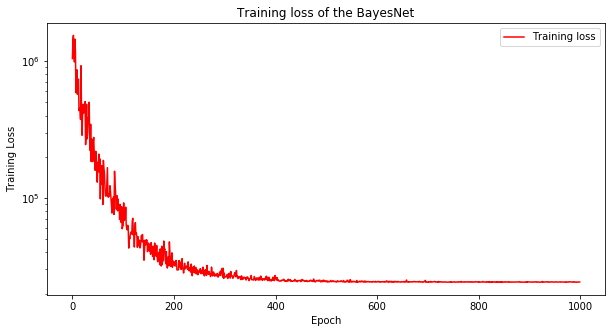

In [11]:
# Train
BNNet = BayesNet(hidden_nodes, KLweight, noise_tol=noise, prior_var=priorvar, prior_mix=prior_mix)
BNNet_trainloss, BNNet_testloss = Train_net(BNNet, epochs, lr, samples, bayes=True)

os.system('say "Finished"')

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(BNNet_trainloss)), BNNet_trainloss, 'r', label='Training loss')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch'), plt.ylabel('Training Loss')
plt.title('Training loss of the BayesNet')
plt.show()


In [1]:
# Test
# BNNet_predictions, CI1, CI2, CIl, CIh, pred_tmp = TestBNN(BNNet, testset)

# Dump the data into a pickle file to reproduce results.
# with open('data.pickle', 'wb') as f:
#    pickle.dump([BNNet_predictions, CI1, CI2, CIl, CIh, pred_tmp], f)
    
# Load the data from a pickle file
# with open('data.pickle', 'rb') as f:
#    [BNNet_predictions, CI1, CI2, CIl, CIh, pred_tmp] = pickle.load(f)


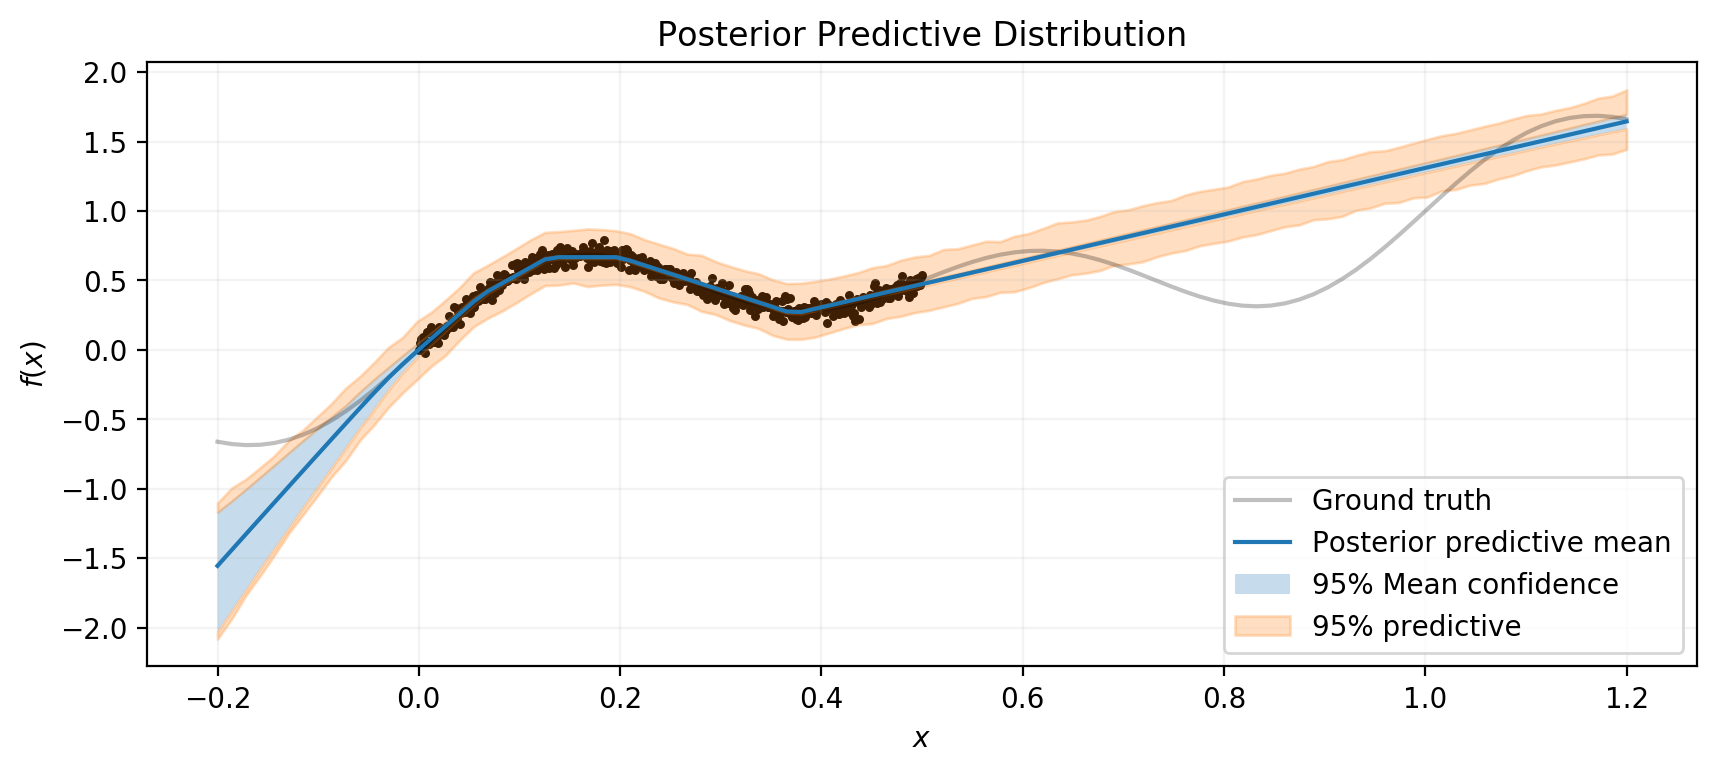

In [52]:
plt.figure(figsize=(10,4), dpi = 200)

plt.title('Posterior Predictive Distribution')

plt.plot(groundTruth, groundTruth_targets, color = 'k', alpha = 0.25, label='Ground truth')
plt.scatter(trainset, trainset_targets, marker='.', c = 'black', s = 20, label='Training data')

plt.plot(testset, BNNet_predictions, label='Posterior predictive mean')
plt.fill_between(testset.reshape(-1), CI1.reshape(-1), CI2.reshape(-1), alpha = 0.25, label='95% Mean confidence')

plt.fill_between(testset.reshape(-1), CI1.reshape(-1), CIl.reshape(-1), alpha = 0.25, color ='#ff7f0e', edgecolor='k',  label='95% predictive')
plt.fill_between(testset.reshape(-1), CI2.reshape(-1), CIh.reshape(-1), alpha = 0.25, color ='#ff7f0e', edgecolor='k', label='95% predictive')

plt.xlabel('$x$'), plt.ylabel('$f(x)$')

# Handle the legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=4);

plt.grid(alpha = 0.15)




# Comparison with (regularised) networks

Generalising the training function for both regular an bayesian nets was too demanding to get it right in all cases. Here, we have decided to not use the same training function. 

In [10]:
# Define an ordinary and a dropout network
class OrdinaryNet(torch.nn.Module):
    def __init__(self, hidden_units):
        super(OrdinaryNet, self).__init__()
        self.activation = torch.nn.ReLU()
        self.FCL1 = torch.nn.Sequential(torch.nn.Linear(1, hidden_units), 
                                        self.activation, 
                                        torch.nn.Linear(hidden_units, 1))
    def forward(self, x):
        x = self.FCL1(x)
        return x


In [11]:
class DropoutNet(torch.nn.Module):
    def __init__(self, hidden_units):
        super(DropoutNet, self).__init__()
        self.activation = torch.nn.ReLU()
        self.FCL1 = torch.nn.Sequential(torch.nn.Linear(1, hidden_units), 
                                        self.activation,
                                        torch.nn.Dropout(0.5),
                                        torch.nn.Linear(hidden_units, 1) )
    def forward(self, x):
        x = self.FCL1(x)
        return x
    

In [17]:
# Vanilla NN
OrdNet  = OrdinaryNet(hidden_nodes)

x, y = Variable(trainset), Variable(trainset_targets)

optimizer = torch.optim.SGD(OrdNet.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

OrdNet_trainloss = []
OrdNet_testloss = []

for t in range(epochs):
    OrdNet.train()
    prediction = OrdNet(x)
    loss = loss_func(prediction, y)     
    optimizer.zero_grad()   
    loss.backward()         
    optimizer.step()       
    OrdNet_trainloss.append(loss)
    
    OrdNet.eval()
    predictions = OrdNet(testset) 
    loss = Error(predictions, testset_targets.detach().numpy())
    OrdNet_testloss.append(loss)
    

In [39]:
# Regularised NN (L2 term)
OrdNetR  = OrdinaryNet(hidden_nodes)

x, y = Variable(trainset), Variable(trainset_targets)

optimizer = torch.optim.SGD(OrdNet.parameters(), lr=0.2, weight_decay=0.001)
loss_func = torch.nn.MSELoss()  

OrdNetR_trainloss = []
OrdNetR_testloss = []

for t in range(epochs):
    OrdNetR.train()
    prediction = OrdNetR(x)
    loss = loss_func(prediction, y)     
    optimizer.zero_grad()   
    loss.backward()         
    optimizer.step()       
    OrdNetR_trainloss.append(loss)
    
    OrdNetR.eval()
    predictions = OrdNetR(testset) 
    loss = Error(predictions, testset_targets.detach().numpy())
    OrdNetR_testloss.append(loss)

In [18]:
# Dropout network
DropNet = DropoutNet(hidden_nodes)
        
x, y = Variable(trainset), Variable(trainset_targets)

optimizer = torch.optim.SGD(DropNet.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  

DropNet_trainloss = []
DropNet_testloss = []

# train the network
for t in range(epochs):
    DropNet.train()
    prediction = DropNet(x)
    loss = loss_func(prediction, y)     
    optimizer.zero_grad()   
    loss.backward()         
    optimizer.step()       
    DropNet_trainloss.append(loss)
    
    DropNet.eval()
    predictions = DropNet(testset) 
    loss = Error(predictions, testset_targets.detach().numpy())
    DropNet_testloss.append(loss)
    


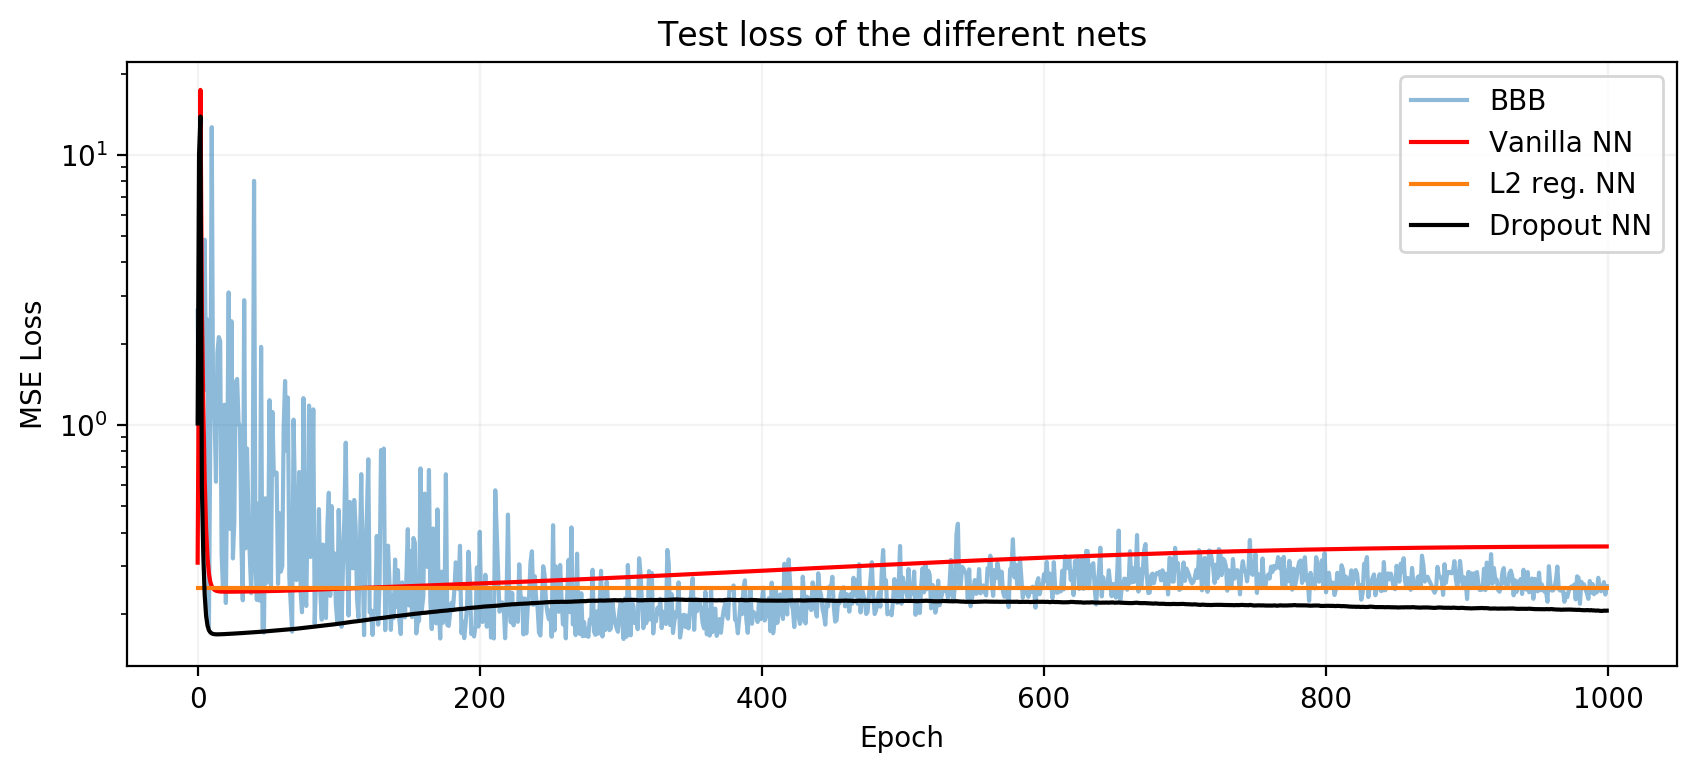

In [50]:
plt.figure(figsize=(10,4), dpi = 200)
plt.plot(np.arange(len(BNNet_testloss)), BNNet_testloss, alpha = 0.5,label='BBB')
plt.plot(np.arange(len(OrdNet_testloss)), OrdNet_testloss, 'r', label='Vanilla NN')
plt.plot(np.arange(len(OrdNet_testloss)), OrdNetR_testloss, label='L2 reg. NN')
plt.plot(np.arange(len(DropNet_testloss)), DropNet_testloss, 'k', label='Dropout NN')
plt.legend()
plt.yscale("log")
plt.xlabel('Epoch'), plt.ylabel('MSE Loss')
plt.title('Test loss of the different nets')
plt.grid(alpha = 0.15)
